# xMEV research into Polygon/Ethereum

## Research Objective

Explore the feasibility of offering a guraantee of equal inclusion of blocks to searchers, enabling them to express an "AND" logic in their SuperBundle.

## Methodology

- Capture data via a Javascript script and upload them as a time-series database to InfluxDB
- Load data in this python notebook
- Visualise a 3-dimensional 

## Data

- Timestamps of the moment that the node became aware of a new block in Polygon
- Timestamps of the moment that the node became aware of a new block in Ethereum
- delta in milliseconds, between the moment the node became aware of a new Ethereum block and the last time that it became aware of a new Polygon block
- number of polygon blocks that were produced between two subsequent ethereum blocks.

# Disclaimer

The first part of this analysis is moot, as it used wrong data. Move to the next Disclaimer part to read the (hopefully) correct  analysis.




In [47]:
# How to get data from InfluxDB

# import requests
# import pandas
# import influxdb_client

# bucket = "xmev"
# org = "biz.r78v54qyd6@gmail.com"
# token = "exCzmT5XjED-7h-WalnF7Yd2kTXOH85dr7EXYbVQDsfwsNCfiZi9NAj7KE1zY1ZaYMrGfCAhpDbbkjZF_2ZhVA=="
# url = "https://europe-west1-1.gcp.cloud2.influxdata.com"
# client = influxdb_client.InfluxDBClient(
#     url=url,
#     token=token,
#     org=org
# )
# query_api = client.query_api()

# query = 'from(bucket: "xmev")\
#   |> range(start: v.timeRangeStart, stop: v.timeRangeStop)\
#   |> filter(fn: (r) => r["_measurement"] == "delta_blocks")\
#   |> filter(fn: (r) => r["_field"] == "delta")\
#   |> aggregateWindow(every: v.windowPeriod, fn: mean, createEmpty: true)\
#   |> yield(name: "mean")'

# result = query_api.query(org=org, query=query)
# print(result)

What we want to model is how the different lag in Ethereum an Polygon affects the possibility of including a bundle in each domain, thus being able to offer an "AND" service to searchers. 

In essence we want to:

- forecast the possibility of a block at the next interval
- model the possibility of a bundle inlclusion at that next block

The data that we have in our disposal are:
- timestamps of new blocks appearence
- time delta between last polygon block and an ethereum block
- numbers of polygon blocks between two subsequent ethereum blocks



In [320]:
# We load the data from a csv fil

import pandas as pd
import numpy as np

from statsmodels.tsa.forecasting.theta import ThetaModel
import matplotlib.pyplot as plt
import ciso8601
import time

plt.rc("figure", figsize=(20,10))
plt.rc("font", size=15)
plt.rc("lines", linewidth=3)


delta_blocks = pd.read_csv('data/delta_blocks.csv', sep=',')
delta_time = pd.read_csv('data/delta_block_time.csv', sep=',')

delta_time.rename(columns={"_time":"Datetime", "_value":"Value"}, inplace=True)
delta_blocks.rename(columns={"_time":"Datetime", "_value":"Value"}, inplace=True)


# delta_blocks.Datetime = delta_blocks.Datetime.map(lambda x: time.mktime(ciso8601.parse_datetime(x).timetuple()))
# delta_time.Datetime = delta_time.Datetime.map(lambda x: time.mktime(ciso8601.parse_datetime(x).timetuple()))
delta_time.Value = delta_time.Value.map(lambda x: float(x) / 1000.0)

td1 = pd.DatetimeIndex(delta_blocks.Datetime, freq='infer')
td2 = pd.DatetimeIndex(delta_time.Datetime, freq='infer')

print(td2)

delta_time_dt_index = delta_time.set_index(td2)
delta_blocks_dt_index = delta_blocks.set_index(td1)

print("DELTA TIME\n")
print(delta_time.head(), "\n")
print("DELTA BLOCKS\n")
print(delta_blocks.head(), "\n")


DatetimeIndex(['2022-03-25 22:30:00+00:00', '2022-03-25 22:30:00+00:00',
               '2022-03-26 08:20:00+00:00', '2022-03-25 22:30:00+00:00',
               '2022-03-25 22:20:00+00:00', '2022-03-26 08:10:00+00:00',
               '2022-03-26 10:10:00+00:00', '2022-03-26 13:40:00+00:00',
               '2022-03-25 22:40:00+00:00', '2022-03-26 10:40:00+00:00',
               ...
               '2022-03-26 16:40:00+00:00', '2022-03-26 13:20:00+00:00',
               '2022-03-26 14:50:00+00:00', '2022-03-26 13:10:00+00:00',
               '2022-03-26 15:20:00+00:00', '2022-03-26 14:10:00+00:00',
               '2022-03-26 15:10:00+00:00', '2022-03-26 15:30:00+00:00',
               '2022-03-26 16:30:00+00:00', '2022-03-26 16:30:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Datetime', length=2515, freq=None)
DELTA TIME

   Unnamed: 0  result  table                          _start  \
0         NaN     NaN      0  2022-03-25T16:03:48.688303399Z   
1         NaN     NaN     

In [ ]:
delta_blocks.Value[0:100].plot()

In [ ]:
delta_time.Value[0:100].plot()

In [321]:
# Let's do some statistical analysis

ts = delta_time.Value
print("Time Delta")
print(f"Median: {ts.median()}s")
print(f"Max: {ts.max()}s")
print(f"Min: {ts.min()}s")

ts = delta_blocks.Value
print("Blocks Delta")
print(f"Median: {ts.median()} block(s)")
print(f"Max: {ts.max()} block(s)")
print(f"Min: {ts.min()} block(s)")

# calibration_df = delta_time_dt_index.Value[:-100]

# tm = ThetaModel(calibration_df, period=1, method="additive")
# res = tm.fit(use_mle=True)
# # print(res.summary())

# forecasts = pd.DataFrame(res.forecast(100))

# delta_time_dt_index.Value.plot()


Time Delta
Median: 7.93s
Max: 84.079s
Min: 0.0s
Blocks Delta
Median: 1.0 block(s)
Max: 4 block(s)
Min: 0 block(s)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -61.025
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2656.95   8.08302e-06       70.1874      0.3347           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       2656.95    1.5499e-07       78.0859      0.3047           1      165   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


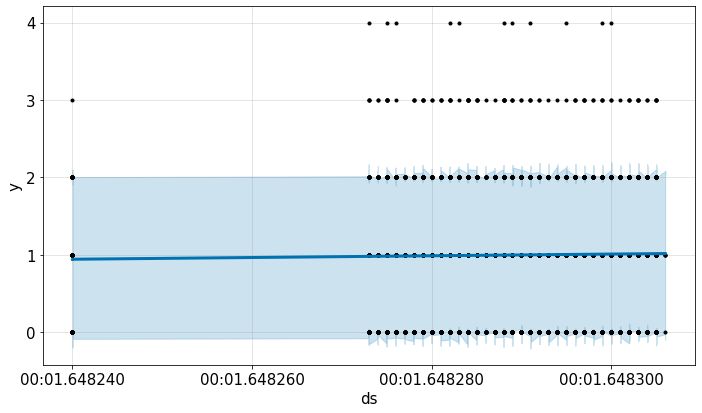

In [322]:
from prophet import Prophet

delta_blocks.Datetime = delta_blocks.Datetime.map(lambda x: time.mktime(ciso8601.parse_datetime(x).timetuple()))
delta_time.Datetime = delta_time.Datetime.map(lambda x: time.mktime(ciso8601.parse_datetime(x).timetuple()))

df = delta_blocks.rename(columns={"Datetime":"ds", "Value":"y"})

m = Prophet()
m.fit(df)

forecast = m.predict(df)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -31.6896
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       3499.29   0.000899454       126.176    6.63e-06       0.001      123  LS failed, Hessian reset 
      99       3499.36   1.50992e-07       90.6618      0.8359      0.8359      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       3499.36   1.71823e-07        83.229      0.8717      0.8717      175   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


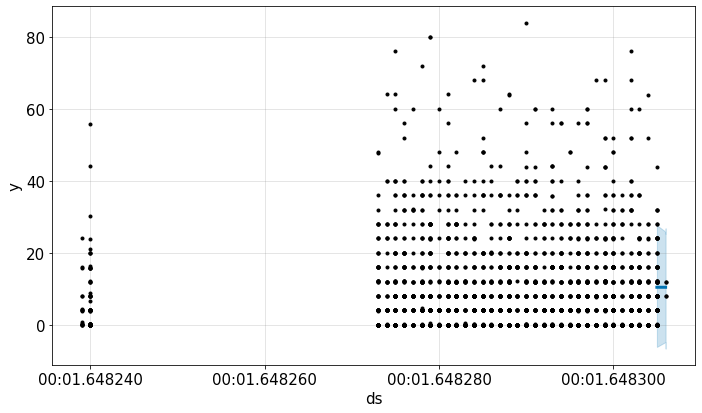

In [323]:
from prophet import Prophet

# delta_blocks.Datetime = delta_blocks.Datetime.map(lambda x: time.mktime(ciso8601.parse_datetime(x).timetuple()))
# delta_time.Datetime = delta_time.Datetime.map(lambda x: time.mktime(ciso8601.parse_datetime(x).timetuple()))

df = delta_time.rename(columns={"Datetime":"ds", "Value":"y"})

m = Prophet()
m.fit(df)

forecast = m.predict(df).tail()

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
# m.plot_components(forecast)


# Disclaimer

The prior analysis is moot because of a small parameter in the capturing script. Due to a default parameter, the script captures on Ethereum blocks, with the two event watchers simply racing every time an ethereum block was produced. That means that we were measuring the different in discovery between 2 event watchers and not between two different domains. 

We repeat the analysis below

Forecasting hasn't proven anything of particular value, but did a mere verification of our intuitive understanding. 

We want to answer the question of erraticity, how lag on the two blockchains affect the possibility of including a bundle in both domains. 

We can get the lag by noting the time at which the block appeared to our node and subtracting it from the timestamp of the block. That will result in a delta of seconds that took the block to propagate through the network and reach us. 

Given that we have that lag, we can again repeat the previous forecasting techniques and see if we can forecast the lag. 


Available data:
- Lag of Ethereum/Polygon blocks
- number of polygon blocks between Ethereum blocks
- time between last polygon block and an ethereum block

The delta times/blocks included the lag, implicitly. This is because they are computed based on the time we observed the new block and not the timestamps of the blocks.

The question is, what affects the inclusion of a bundle and how we can model. The model will tell us if the time-series we have are enough or we need more type of data to complete the model.

Based on the Flashbots Auction, we see that the inclusion rule is rather "simple", at least intuitively. It's all about the most profitable bundle for the miner. Thus, we can safely make "working assumption" that the bunldes we will consider in our analysis have been correctly priced by the searcher and are profitable enough for the miners to include them, whenever they are submitted. With this working assumption, our focus is on "when" to submit said bundles and if the relay can deterministically say that both bundles will get included. 

We **know** that Polygon Blocks are produced every ~2.7 seconds and Ethereum blocks every ~14 seconds.

## Observations
- time-delta
- block-delta
- domain lag

Bellow you can find an apt description of each type of data and some diagrams from statistical and forecasting analysis. Forecasting needs **much** more calibration to be effective, as the data don't have any obvious seasonality or period. We must work backwards and discover if they follow some seasonality, so that the forecasting methods can be more active. Since they are the result of humans, we can expect that some periodicity will be shown (e.g more active during weekdays). Nevertheless that periodcity is not obvious in any of the data listed and thus most forecasting methods we tried (naive) did not showcase any particularly useful result, other than verifying our intuitions.

## Verdict

We see that the time-delta is miniscule and borderline negative, that means that polygon blocks appear about the same time as Ethereum blocks, and perhaps a couple of `ms` after them. This is good news, as it means that if we can predict when they will appear, we can treat the state transition of the two domains as "sync-ish".

Block-delta is erratic. It's very hard to make any forecasting with the methods we found and that can lead to problems. The prolbem is that we don't know at which polygon block a new thereum block will appear. There may be 40 polygon blocks, or 0. We see a median of 4 blocks, but the STD is quite high, so more variables are required to lower the uncertainty. As we have in our analysis, we want to submit the bundle at the very last possible time, so that we can re-evaluate the MEV opportunity at every new Polygon state and use the last Polygon state before the new Ethereum State as the canonical state to decide on the MEV opportunity. 

The Domain lag is also not very good, at least with Ethereum. While in Polygon is quite constant and with a reasonable STD of ~2s, its' about ~20s for Ethereum. That means that we can't use the Ethereum network as a good way to find out about inclusion, especially given the short amount of time that we have to evaluate the MEV opportunity, decide the last polygon state (as mentioned above) and then issue the bundles to be included in the next blocks. 

The high block-delta means that having a scheme where the miners "commit" to the inclusion of a bundle and then they include them is propably worth exploring, as we can't forecast effectively at which Polygon block we need to issue the MEV bundles. With a commitment from both parties and then by giving them the "go-ahead", the relay can be certain  that both bundles will be included, even if we don't know the exact time of the state transition. It's worth mentioning that given the Ethereum erratic behaviour, the best way to issue MEV opportunities is to issue the Polygon Bundle at the moment the Ethereum block is discovered. That means that there is a very high chance the Polygon bundle will be included at about the same time or before the next Ethereum block. Of course, if the Ethereum block takes a lot of time to appear, MEV alpha may leak from the Polygon bundle that will have been landed and will be available for analysis by other bots (who may frontrun the Ethereum TX that "seals" the MEV).

The high domain lag means that the bi-directional event stream between relayer(s) and block producers is definetely worth the effort, as it will limit this discovery lag to the absolute minimum. That may lead to better forecasting and more deterministic view of the systems


### Time-delta

We view that most of the time delta, between the discovery of an ethereum block and a polygon block is actually negative, at the area of ~20ms. This signifies two things:
- Blocks are discovered at about the same time
- Negative values are due to the script's event loop and how it handles concurrent events

This information is powerful, because that means that the state transition happens at *about* the same time. If we can succesfuly forecast the block at which this "sync-ish" transition happens, then we have a very good first model for cross-domain MEV. 

In [130]:
# We load the data from a csv fil

import pandas as pd
import numpy as np

from statsmodels.tsa.forecasting.theta import ThetaModel
import matplotlib.pyplot as plt
import ciso8601
import time

plt.rc("figure", figsize=(20,10))
plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

delta_time_correct = pd.read_csv('data/delta_block_time_correct.csv', sep=',')

delta_time_correct.rename(columns={"timestamp":"Datetime", "_value":"Value"}, inplace=True)

# delta_blocks.Datetime = delta_blocks.Datetime.map(lambda x: time.mktime(ciso8601.parse_datetime(x).timetuple()))
# delta_time.Datetime = delta_time.Datetime.map(lambda x: time.mktime(ciso8601.parse_datetime(x).timetuple()))
# delta_time_correct.Value = delta_time.Value.map(lambda x: float(x) / 1000.0)

td2 = pd.DatetimeIndex(delta_time_correct.Datetime, freq='infer')

# print(td2)

delta_time_dt_index_correct = delta_time_correct.set_index(td2)

print("DELTA TIME\n")
print(delta_time_correct.head(), "\n")


DELTA TIME

   Unnamed: 0  result  table                          _start  \
0         NaN     NaN      0  2022-03-28T07:24:03.456036927Z   
1         NaN     NaN      1  2022-03-28T07:24:03.456036927Z   
2         NaN     NaN      2  2022-03-28T07:24:03.456036927Z   
3         NaN     NaN      3  2022-03-28T07:24:03.456036927Z   
4         NaN     NaN      4  2022-03-28T07:24:03.456036927Z   

                            _stop                 _time  Value _field  \
0  2022-03-28T10:24:03.456036927Z  2022-03-28T07:44:00Z  -27.0  delta   
1  2022-03-28T10:24:03.456036927Z  2022-03-28T09:20:00Z   11.0  delta   
2  2022-03-28T10:24:03.456036927Z  2022-03-28T09:25:00Z   22.0  delta   
3  2022-03-28T10:24:03.456036927Z  2022-03-28T10:17:00Z  -20.0  delta   
4  2022-03-28T10:24:03.456036927Z  2022-03-28T10:17:00Z   11.0  delta   

       _measurement          host       Datetime  
0  delta_block_time  xmev-capture  1648453417807  
1  delta_block_time  xmev-capture  1648459161978  
2  delta_bl

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Time Delta
Median: -21.0 ms
Max: 4053.0 ms
Min: -684.6666666666666 ms
STD: 722.3084339526334 ms

Initial log joint probability = -12.6613
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       799.174   0.000262102       79.0602       0.497       0.497      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       799.182   5.91452e-05       60.3713   8.428e-07       0.001      191  LS failed, Hessian reset 
     152       799.186   8.29816e-06       78.0923   1.053e-07       0.001      296  LS failed, Hessian reset 
     174       799.187   3.42569e-08       53.6493      0.1055      0.5504      328   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


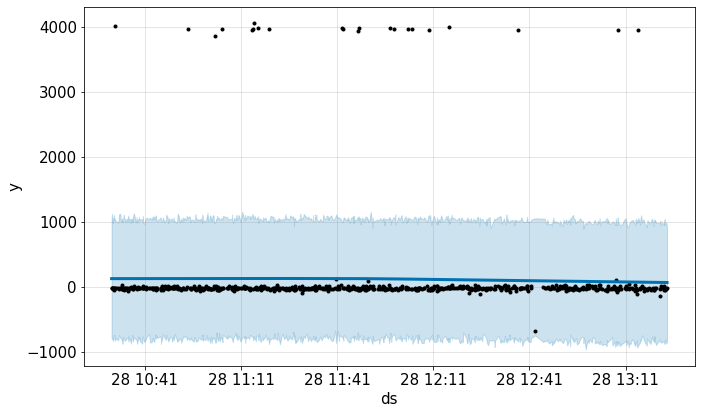

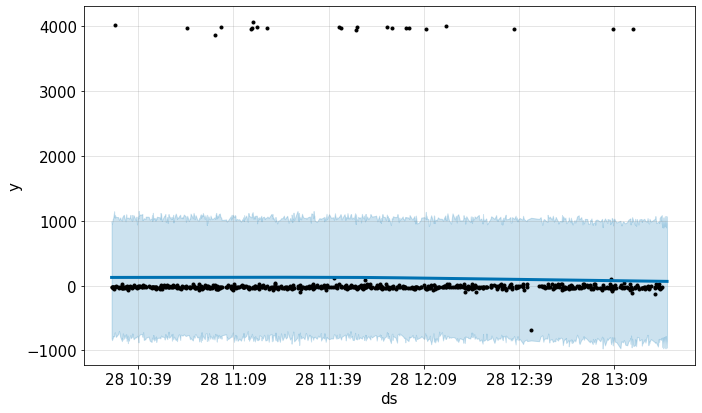

In [132]:
from prophet import Prophet 
from datetime import datetime


ts = delta_time_correct.Value
print("Time Delta")
print(f"Median: {ts.median()} ms")
print(f"Max: {ts.max()} ms")
print(f"Min: {ts.min()} ms")
print(f"STD: {ts.std()} ms")
print()


df = delta_time_correct.rename(columns={"Datetime":"ds", "Value":"y"})
df.ds = df.ds.map(lambda x: datetime.fromtimestamp(x/1000))

m = Prophet()
m.fit(df)

forecast = m.predict(df)
fig1 = m.plot(forecast)
future = m.make_future_dataframe(periods=100, freq='S')
fcst = m.predict(future)
fig = m.plot(fcst)

# m.plot_components(forecast)

### Block-delta

The numbers of polygon blocks between two subsequent ethereum blocks are erratic and as the analysis below shows, not trivial to forecast. The block-delta is not promising for helping us predict **when** a new block will be mined.

In [324]:
# We load the data from a csv fil

import pandas as pd
import numpy as np

from statsmodels.tsa.forecasting.theta import ThetaModel
import matplotlib.pyplot as plt
import ciso8601
import time

plt.rc("figure", figsize=(20,10))
plt.rc("font", size=15)
plt.rc("lines", linewidth=3)


delta_blocks_correct = pd.read_csv('data/delta_blocks_correct.csv', sep=',')
# delta_time_correct = pd.read_csv('data/delta_block_time.csv', sep=',')

# delta_time.rename(columns={"_time":"Datetime", "_value":"Value"}, inplace=True)
delta_blocks_correct.rename(columns={"timestamp":"Datetime", "_value":"Value"}, inplace=True)

# delta_blocks.Datetime = delta_blocks.Datetime.map(lambda x: time.mktime(ciso8601.parse_datetime(x).timetuple()))
# delta_time.Datetime = delta_time.Datetime.map(lambda x: time.mktime(ciso8601.parse_datetime(x).timetuple()))
# delta_time_correct.Value = delta_time.Value.map(lambda x: float(x) / 1000.0)

td1 = pd.DatetimeIndex(delta_blocks_correct.Datetime, freq='infer')
# td2 = pd.DatetimeIndex(delta_time_correct.Datetime, freq='infer')

# print(td2)

# delta_time_dt_index_correct = delta_time_correct.set_index(td2)
delta_blocks_dt_index_correct = delta_blocks_correct.set_index(td1)

# print("DELTA TIME\n")
# print(delta_time.head(), "\n")




INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Block Delta
Median: 4.0 blocks
Max: 40 blocks
Min: 0 blocks
STD: 6.093702714998689 blocks

Initial log joint probability = -6.69757
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       331.639   0.000287336       103.541   2.904e-06       0.001      120  LS failed, Hessian reset 
      99       331.659   1.57927e-07       105.936      0.3852      0.3852      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       331.659   8.11173e-09       97.0383      0.6626      0.6626      178   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


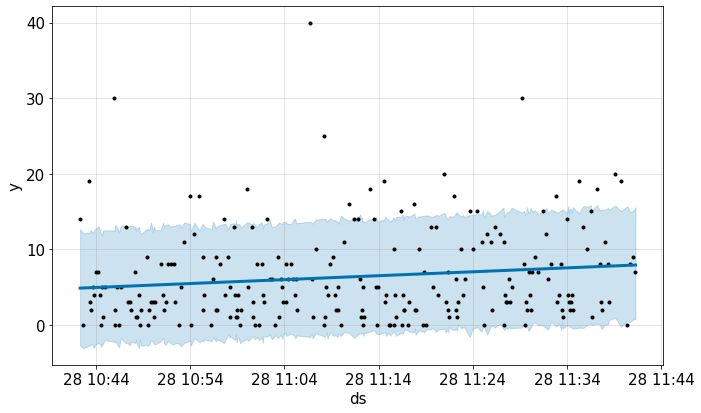

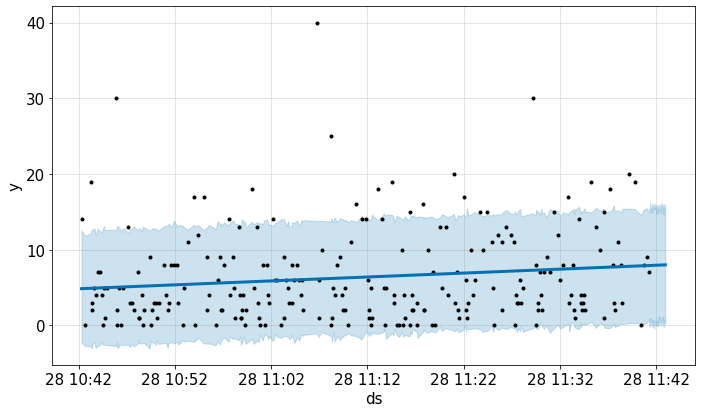

In [329]:
from prophet import Prophet 
from datetime import datetime
from prophet.diagnostics import cross_validation


ts = delta_blocks_correct.Value
print("Block Delta")
print(f"Median: {ts.median()} blocks")
print(f"Max: {ts.max()} blocks")
print(f"Min: {ts.min()} blocks")
print(f"STD: {ts.std()} blocks")
print()


df = delta_blocks_correct.rename(columns={"Datetime":"ds", "Value":"y"})
df.ds = df.ds.map(lambda x: datetime.fromtimestamp(x/1000))

m = Prophet()
m.fit(df)

forecast = m.predict(df)
fig1 = m.plot(forecast)
future = m.make_future_dataframe(periods=100, freq='S')
fcst = m.predict(future)
fig = m.plot(fcst)


# m.plot_components(forecast)

In [ ]:
import pandas as pd
import numpy as np

from statsmodels.tsa.forecasting.theta import ThetaModel
import matplotlib.pyplot as plt

calibration_df = delta_blocks_correct.Value[:-5]

tm = ThetaModel(calibration_df, period=1, method="additive")
res = tm.fit(use_mle=True) 
res.plot_predict(5, theta=2)
print(res.summary())
forecasts = pd.DataFrame(res.forecast(5))
plt.plot(delta_blocks_correct.Value)
plt.plot(forecasts)
plt.show()

print("DROP OUTLIERS")

calibration_df = delta_blocks_correct.Value[:-5]

i = 0
for value in calibration_df:
    if value > 20:
        calibration_df[i] = 0
    i = i + 1

tm = ThetaModel(calibration_df, period=1, method="additive")
res = tm.fit(use_mle=True) 
res.plot_predict(5, theta=2)
print(res.summary())
forecasts = pd.DataFrame(res.forecast(5))
plt.plot(delta_blocks_correct.Value)
plt.plot(forecasts)
plt.show()

                            AutoReg Model Results                             
Dep. Variable:                  Value   No. Observations:                  233
Model:                     AutoReg(3)   Log Likelihood                -743.601
Method:               Conditional MLE   S.D. of innovations              6.136
Date:                Mon, 28 Mar 2022   AIC                           1497.202
Time:                        13:10:26   BIC                           1514.392
Sample:                             3   HQIC                          1504.136
                                  233                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9975      0.842      8.308      0.000       5.347       8.648
Value.L1      -0.0469      0.066     -0.714      0.475      -0.176       0.082
Value.L2       0.0091      0.066      0.137      0.8

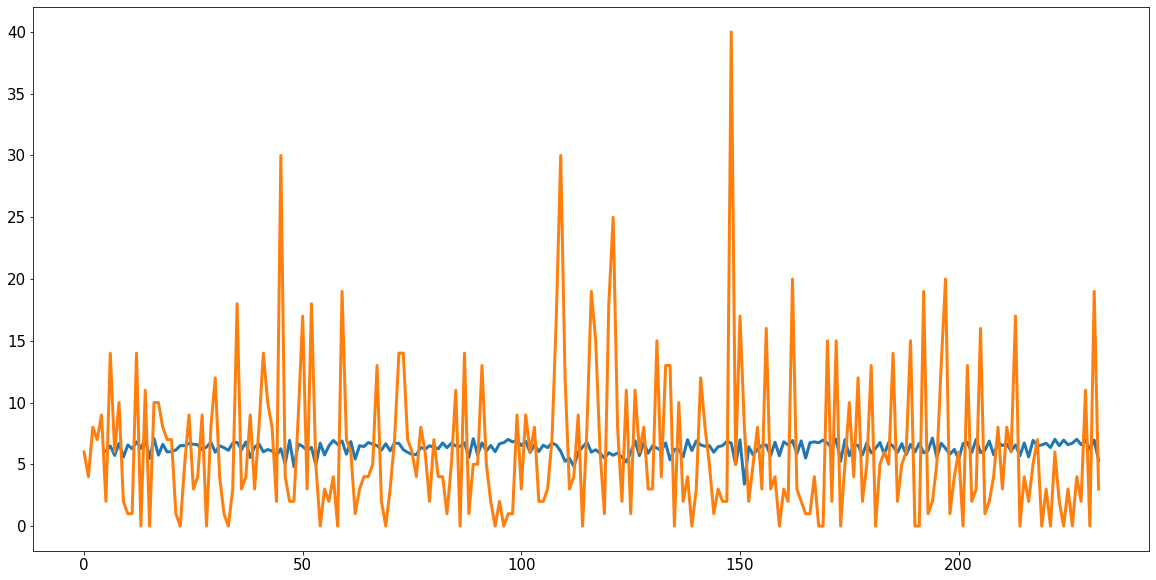

In [100]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

mod = AutoReg(calibration_df, 3, old_names=False)
res = mod.fit()
print(res.summary())
plt.plot(res.predict(5))
plt.plot(calibration_df)
plt.show()

### Domain Lag

From the analysis below, we see that Polygon has a substantiall lower network lag, wtith a much lower STD and more reasonable upper and lower bounds. This is not the case for Ethereum, where the lag is substantial, to say the least. 

A quick analysis showcase that an off-chain bidirectional channel between the Block Producers and the Relay would be paramount, as the network view can really hinder the ability of the relay to quickly verify the inclusion of a bundle in one domain and then signal the inclusion to another. 

The above is not an "IF THEN THAT" grammar, but a mere practical fact, that out of necessity one bundle will be included before the other, as the blockchains change states in async to one another


In [328]:
# We load the data from a csv fil

import pandas as pd
import numpy as np

from statsmodels.tsa.forecasting.theta import ThetaModel
import matplotlib.pyplot as plt
import ciso8601
import time

plt.rc("figure", figsize=(20,10))
plt.rc("font", size=15)
plt.rc("lines", linewidth=3)


lag = pd.read_csv('data/lag_correct.csv', sep=',')
print(lag)
pol_lag = pd.DataFrame(columns=["Value", "timestamp"])
eth_lag = pd.DataFrame(columns=["Value", "timestamp"])

i=0
for item in lag._measurement:
    val = pd.DataFrame([[lag._value[i], lag.timestamp[i]]], columns=["Value", "timestamp"])
    if item == "polygon_lag":
        pol_lag = pd.concat([pol_lag, val])
    else:
        eth_lag = pd.concat([eth_lag, val])
    i+=1
print(eth_lag)
print(pol_lag)

eth_lag = eth_lag.reset_index()
pol_lag = pol_lag.reset_index()


      Unnamed: 0  result  table                          _start  \
0            NaN     NaN      0  2022-03-28T07:20:12.459234443Z   
1            NaN     NaN      1  2022-03-28T07:20:12.459234443Z   
2            NaN     NaN      2  2022-03-28T07:20:12.459234443Z   
3            NaN     NaN      3  2022-03-28T07:20:12.459234443Z   
4            NaN     NaN      4  2022-03-28T07:20:12.459234443Z   
...          ...     ...    ...                             ...   
3099         NaN     NaN   3099  2022-03-28T07:20:12.459234443Z   
3100         NaN     NaN   3100  2022-03-28T07:20:12.459234443Z   
3101         NaN     NaN   3101  2022-03-28T07:20:12.459234443Z   
3102         NaN     NaN   3102  2022-03-28T07:20:12.459234443Z   
3103         NaN     NaN   3103  2022-03-28T07:20:12.459234443Z   

                               _stop                 _time  _value _field  \
0     2022-03-28T10:20:12.459234443Z  2022-03-28T07:42:00Z     2.0    lag   
1     2022-03-28T10:20:12.459234443Z  202

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Eth Lag
Median: 13.0 s
Max: 85.0 s
Min: -1.0 s
STD: 12.940090780412147 s

Polygon Lag
Median: 6.0 s
Max: 11.0 s
Min: 1.0 s
STD: 2.184077774987351 s

Initial log joint probability = -11.1029
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       887.878   0.000360536       117.074   4.169e-06       0.001      138  LS failed, Hessian reset 
      99       887.892   3.70629e-05       61.3424      0.5881           1      150   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       887.897   2.14239e-05       115.054   2.864e-07       0.001      264  LS failed, Hessian reset 
     199       887.898   1.35165e-06       91.1097      0.9074      0.9074      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       887.898   5.41426e-09       93.4798      0.1449      0.1449      332   
Optimization terminated normally: 
  Convergence de

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -103.914
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2851.18    0.00595737       85.5168           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134        2852.2   0.000295074       77.2686   3.754e-06       0.001      219  LS failed, Hessian reset 
     199        2852.3   0.000119574        69.816       1.559      0.5028      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236        2852.3   3.95401e-07        79.778       1.357      0.3593      352   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


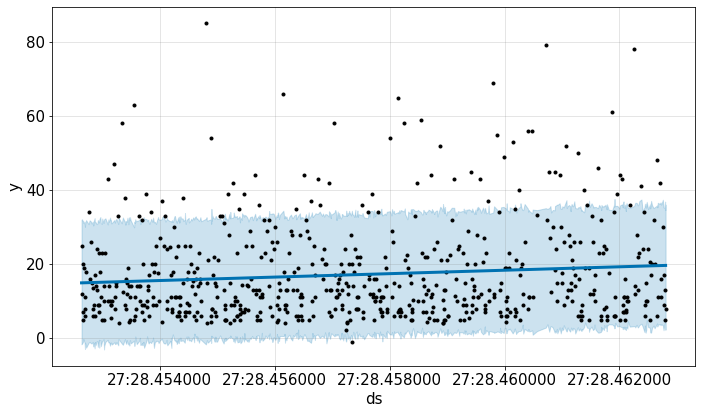

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet

ts = eth_lag.Value
print("Eth Lag")
print(f"Median: {ts.median()} s")
print(f"Max: {ts.max()} s")
print(f"Min: {ts.min()} s")
print(f"STD: {ts.std()} s")
print()

ts = pol_lag.Value
print("Polygon Lag")
print(f"Median: {ts.median()} s")
print(f"Max: {ts.max()} s")
print(f"Min: {ts.min()} s")
print(f"STD: {ts.std()} s")
print()
      

calibration_df = eth_lag.Value

df = eth_lag.rename(columns={"timestamp":"ds", "Value":"y"})


m = Prophet()
m.fit(df)
forecast = m.predict(df)
fig1 = m.plot(forecast)

calibration_df = pol_lag.Value

df = pol_lag.rename(columns={"timestamp":"ds", "Value":"y"})


m = Prophet()
m.fit(df)
forecast = m.predict(df)
fig1 = m.plot(forecast)


                              ThetaModel Results                              
Dep. Variable:                  Value   No. Observations:                  589
Method:                           MLE   Deseasonalized:                   True
Date:                Mon, 28 Mar 2022   Deseas. Method:         Multiplicative
Time:                        17:56:49   Period:                              1
Sample:                             0                                         
                                  589                                         
    Parameter Estimates    
            Parameters     
---------------------------
b0    0.0021625474732438277
alpha 1.907372876275293e-05
---------------------------


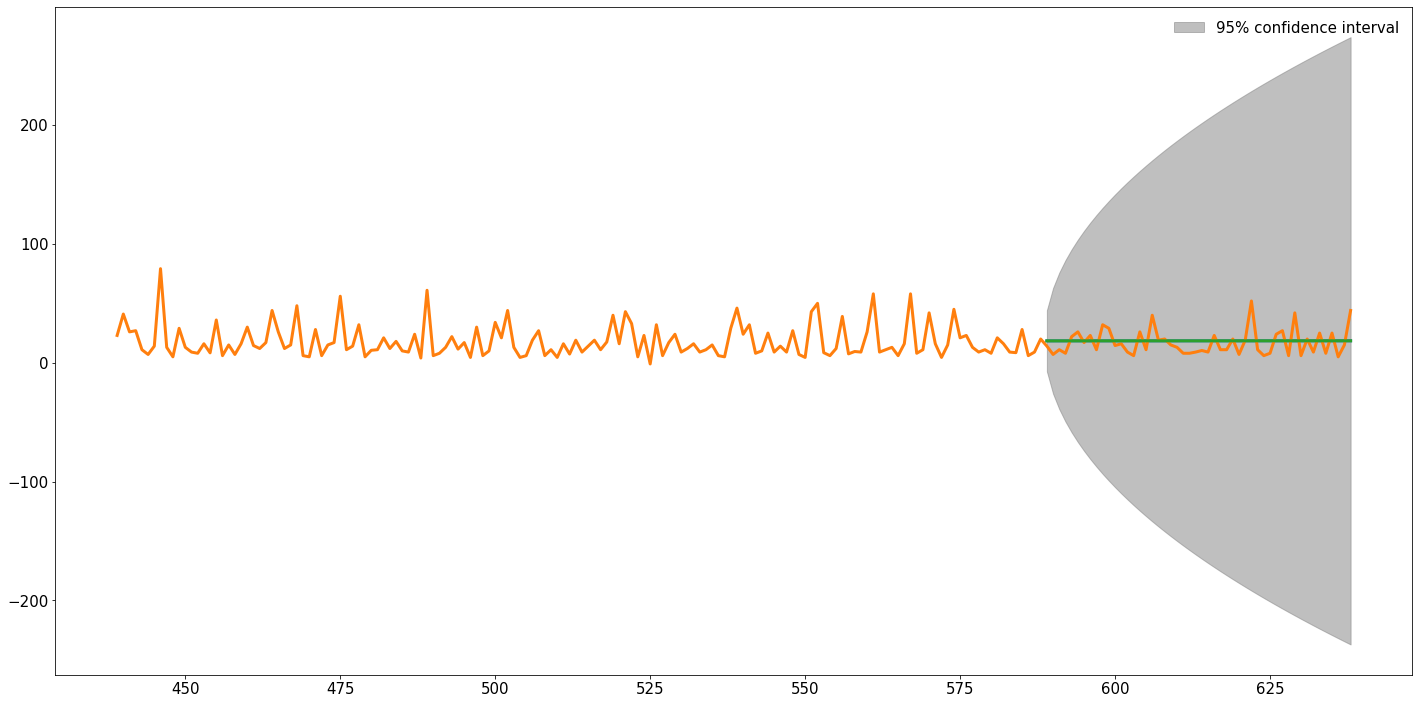

                              ThetaModel Results                              
Dep. Variable:                  Value   No. Observations:                 2415
Method:                           MLE   Deseasonalized:                   True
Date:                Mon, 28 Mar 2022   Deseas. Method:         Multiplicative
Time:                        17:56:50   Period:                              3
Sample:                             0                                         
                                 2415                                         
    Parameter Estimates    
            Parameters     
---------------------------
b0      8.0185226838124e-05
alpha 8.948951264098337e-05
---------------------------


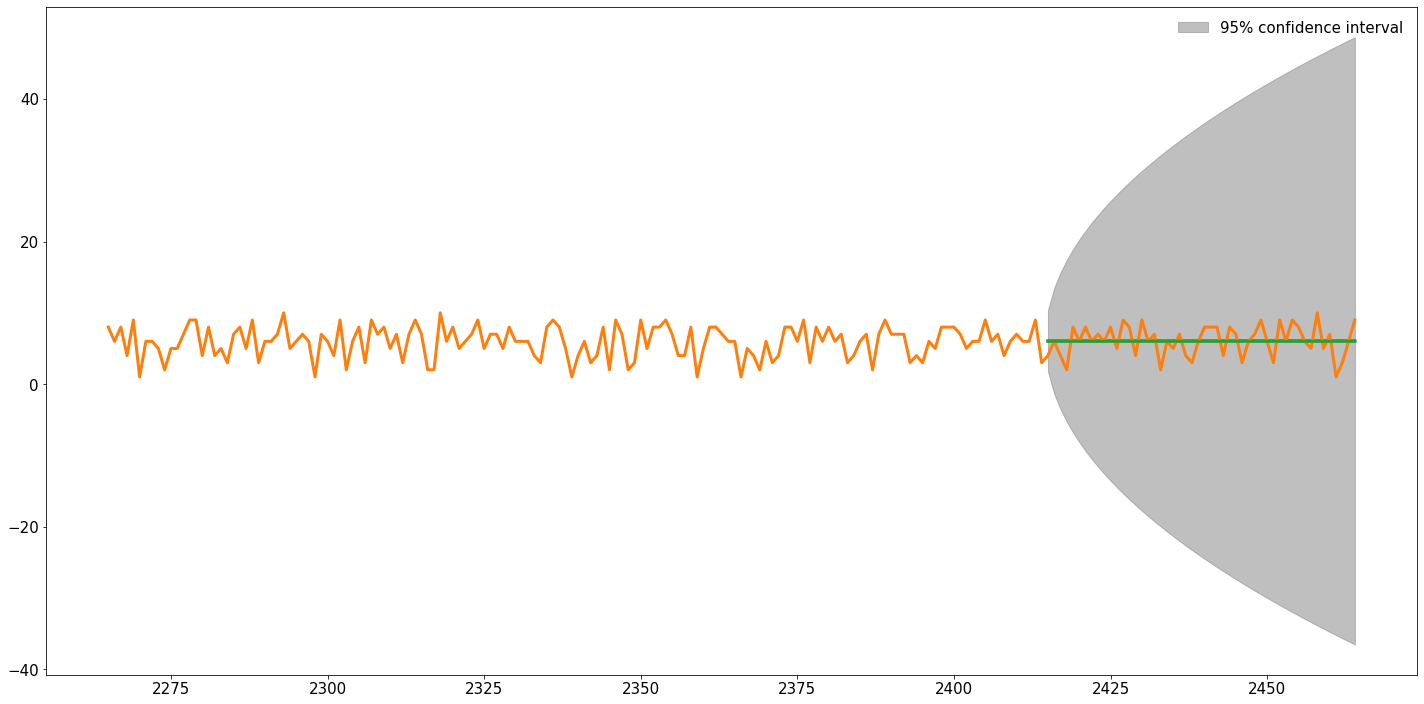

In [327]:
import pandas as pd
import numpy as np

from statsmodels.tsa.forecasting.theta import ThetaModel
import matplotlib.pyplot as plt


calibration_df = eth_lag.Value[:-50]

tm = ThetaModel(calibration_df, period=1, method="multiplicative")
res = tm.fit(use_mle=True) 
res.plot_predict(50)
print(res.summary())
forecasts = pd.DataFrame(res.forecast(50))
plt.plot(eth_lag.Value[-200:])
plt.plot(forecasts)
plt.show()

calibration_df = pol_lag.Value[:-50]

tm = ThetaModel(calibration_df, period=3, method="multiplicative")
res = tm.fit(use_mle=True) 
res.plot_predict(50, theta=10)
print(res.summary())
forecasts = pd.DataFrame(res.forecast(50))
plt.plot(pol_lag.Value[-200:])
plt.plot(forecasts)
plt.show()